In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

2024-05-16 01:50:55.375776: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 01:50:55.378393: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 01:50:55.414710: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 01:50:55.415262: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 01:50:56.137416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
X = np.load('X.npy')
y = np.load('y.npy')
print("len(X):", len(X))
print("len(y):", len(y))

len(X): 1475
len(y): 1475


In [3]:
num_classes = 5
y = tf.keras.utils.to_categorical(y, num_classes)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print("len(X_train):", len(X_train))
print("len(X_test):", len(X_test))
print("len(y_train):", len(y_train))
print("len(y_test):", len(y_test))

len(X_train): 1180
len(X_test): 295
len(y_train): 1180
len(y_test): 295


In [6]:
X_train[0].shape

(62, 128)

In [16]:
import tensorflow as tf
from tensorflow.keras import regularizers


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(62, 128), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ELU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ELU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ELU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ELU(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ELU(),
    tf.keras.layers.Dense(5, activation='softmax')
], name='vggish_embedding_model')


learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Compile the model
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=METRICS)


model.summary()

Model: "vggish_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 7936)              0         
                                                                 
 dense_14 (Dense)            (None, 2048)              16254976  
                                                                 
 batch_normalization_8 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 elu_10 (ELU)                (None, 2048)              0         
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 1024)              2098176   
                                            

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=EPOCHS//3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_test, y_test), batch_size=64,callbacks=[early_stopping])

Epoch 1/10
19/19 [==============================] - 12s 451ms/step - loss: 6.0939 - accuracy: 0.7331 - precision: 0.7935 - recall: 0.6873 - val_loss: 19.7843 - val_accuracy: 0.2780 - val_precision: 0.2780 - val_recall: 0.2780
Epoch 2/10
19/19 [==============================] - 5s 266ms/step - loss: 5.4544 - accuracy: 0.9441 - precision: 0.9509 - recall: 0.9356 - val_loss: 17.3639 - val_accuracy: 0.2983 - val_precision: 0.2983 - val_recall: 0.2983
Epoch 3/10
19/19 [==============================] - 5s 268ms/step - loss: 4.8677 - accuracy: 0.9822 - precision: 0.9830 - recall: 0.9805 - val_loss: 15.9840 - val_accuracy: 0.2949 - val_precision: 0.2949 - val_recall: 0.2949
Epoch 4/10
19/19 [==============================] - 5s 260ms/step - loss: 4.2958 - accuracy: 0.9856 - precision: 0.9864 - recall: 0.9847 - val_loss: 10.4682 - val_accuracy: 0.4983 - val_precision: 0.4966 - val_recall: 0.4915
Epoch 5/10
19/19 [==============================] - 5s 256ms/step - loss: 3.7673 - accuracy: 0.9881

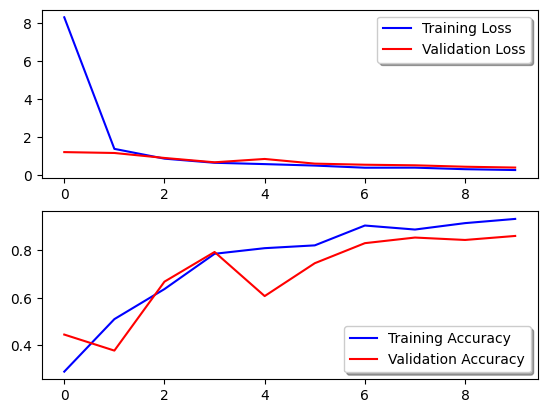

In [9]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [10]:
evaluation = model.evaluate(X_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

10/10 [==============================] - 0s 3ms/step - loss: 0.4034 - accuracy: 0.8610 - precision: 0.9060 - recall: 0.8169
Test Accuracy : 86.10%


10/10 [==============================] - 0s 3ms/step


<Axes: >

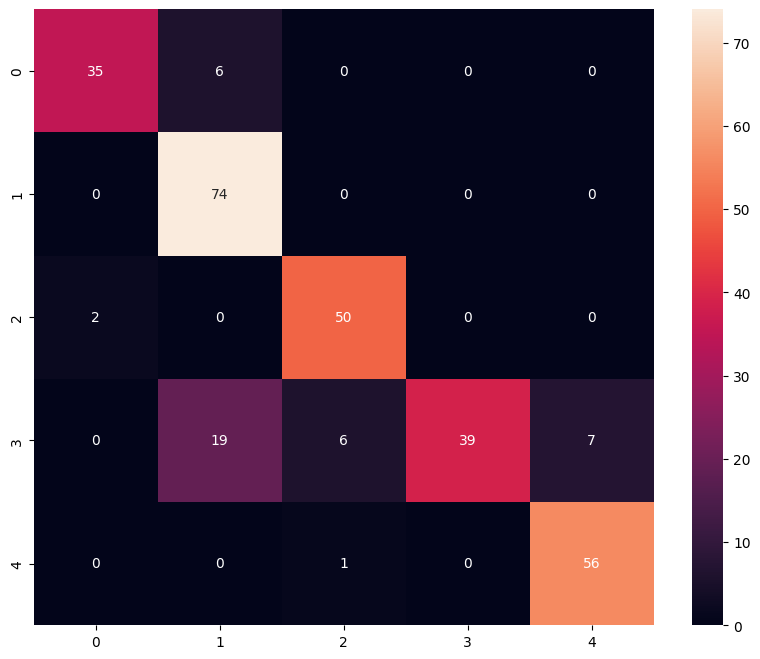

In [11]:
# Predict the values from the testing dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

In [12]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90        41
           1       0.75      1.00      0.86        74
           2       0.88      0.96      0.92        52
           3       1.00      0.55      0.71        71
           4       0.89      0.98      0.93        57

    accuracy                           0.86       295
   macro avg       0.89      0.87      0.86       295
weighted avg       0.89      0.86      0.85       295



In [16]:
model.save('VGGish_model.h5')

/home/hassan/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
